# NitroFusion Demo Code
Repository can be found at https://github.com/ChenDarYen/NitroFusion/tree/main

In [1]:
# Suppress warnings and set OpenMP config
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# Core imports for model
import torch
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

# For image display
from IPython.display import display
from PIL import Image

# Custom scheduler class
from diffusers import LCMScheduler

In [2]:
# Check if CUDA (GPU acceleration) is available on your system
# Returns True if you can use your NVIDIA GPU, False if you're limited to CPU
print(f"CUDA available: {torch.cuda.is_available()}")

# Display the version of CUDA installed on your system
# This is important because different versions of PyTorch require specific CUDA versions
print(f"CUDA version: {torch.version.cuda}")

# Optional: You can also check which GPU you're using
if torch.cuda.is_available():
    print(f"GPU being used: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA version: 11.8
GPU being used: NVIDIA GeForce RTX 4070 SUPER


In [3]:
# Check which version of PyTorch is installed
# This is important because:
# 1. Different PyTorch versions may require different CUDA versions
# 2. Some model features might only work with specific PyTorch versions
# 3. Helps with troubleshooting compatibility issues
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1


In [4]:
# Import the base scheduler class we'll extend
from diffusers import LCMScheduler

class TimestepShiftLCMScheduler(LCMScheduler):
    def __init__(self, *args, shifted_timestep=250, **kwargs):
        # Initialize the parent LCMScheduler class
        super().__init__(*args, **kwargs)
        # Register our new configuration parameter
        self.register_to_config(shifted_timestep=shifted_timestep)

    def set_timesteps(self, *args, **kwargs):
        # First, let the parent class set up its timesteps
        super().set_timesteps(*args, **kwargs)
        # Save the original timesteps for later use
        self.origin_timesteps = self.timesteps.clone()
        # Create modified timesteps based on our shifted_timestep configuration
        self.shifted_timesteps = (self.timesteps * self.config.shifted_timestep / self.config.num_train_timesteps).long()
        # Update current timesteps to use our modified version
        self.timesteps = self.shifted_timesteps

    def step(self, model_output, timestep, sample, generator=None, return_dict=True):
        # Initialize step index if not already done
        if self.step_index is None:
            self._init_step_index(timestep)
        # Temporarily restore original timesteps for parent class step
        self.timesteps = self.origin_timesteps
        # Let parent class perform its step operation
        output = super().step(model_output, timestep, sample, generator, return_dict)
        # Restore our modified timesteps
        self.timesteps = self.shifted_timesteps
        return output

The config attributes {'clip_sample': False, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True} were passed to TimestepShiftLCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

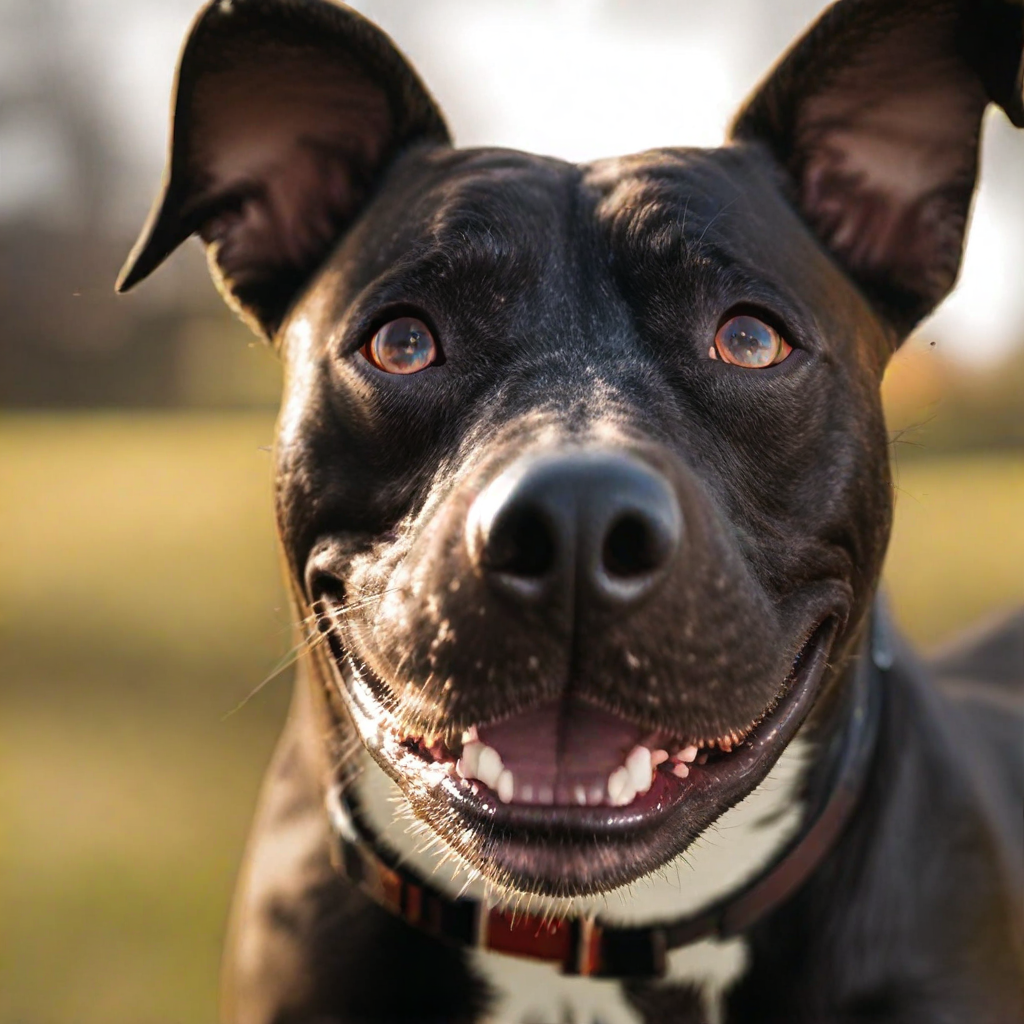

In [5]:
# Define the base model and repository information
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"  # The main model we're building from
repo = "ChenDY/NitroFusion"                                 # Repository with our specialized model weights

# Setup for NitroSD-Realism model variant
ckpt = "nitrosd-realism_unet.safetensors"                  # Checkpoint file for the realistic style model

# Initialize the UNet model architecture and move it to GPU with half precision
unet = UNet2DConditionModel.from_config(base_model_id, subfolder="unet").to("cuda", torch.float16)

# Load the specialized weights into our UNet model
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))

# Initialize our custom scheduler with specific settings for realistic results
scheduler = TimestepShiftLCMScheduler.from_pretrained(
    base_model_id,                 # Base model configuration
    subfolder="scheduler",         # Location of scheduler files
    shifted_timestep=250,          # Timestep value tuned for realistic outputs
)

# Set the number of inference steps for generation
scheduler.config.original_inference_steps = 4  # Lower numbers = faster generation, higher = potentially better quality

# Create the complete pipeline by combining all components
pipe = DiffusionPipeline.from_pretrained(
    base_model_id,                 # Base model path
    unet=unet,                     # Our specialized UNet model
    scheduler=scheduler,           # Our custom scheduler
    torch_dtype=torch.float16,     # Use half precision for efficiency
    variant="fp16",               # Use 16-bit floating point
).to("cuda")                      # Move pipeline to GPU

# Example prompt for generating an image
prompt = "A photo of a stafforshire bull terrier with a big smile on its face."

# Generate the image using our pipeline
image = pipe(
    prompt=prompt,                 # The text description of our desired image
    num_inference_steps=1,         # Fast generation with just 1 step
    guidance_scale=0,              # No classifier-free guidance (pure noise prediction)
).images[0]                        # Get the first (and only) generated image

#show the image
display(image)